In [2]:
import scipy.io
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [3]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Load data from .mat file
mat = scipy.io.loadmat('trainData.mat')

In [5]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Fault_Signals', 'VInorm', 'fault_locations'])

In [6]:
# Extract data from the MATLAB structure
localization_labels = mat['fault_locations'].T 
fault_signals = mat['Fault_Signals']   
VInorm = mat['VInorm']           

In [7]:
# Convert to PyTorch tensors and move to GPU if available
fault_signals = torch.tensor(fault_signals, dtype=torch.float32).to(device)
VInorm = torch.tensor(VInorm, dtype=torch.float32).to(device)
localization_labels = torch.tensor(localization_labels, dtype=torch.float32).to(device)

# Assuming segmentation labels are part of fault_signals
segmentation_labels = fault_signals


In [15]:
localization_labels.T.shape

torch.Size([500, 2])

In [9]:
num_samples = localization_labels.shape[1]

In [10]:
num_samples

500

### Re-shape each tensor for better understanding

In [11]:
fault_signals = fault_signals.reshape(num_samples,-1,2)
print(fault_signals.shape)

torch.Size([500, 20001, 2])


In [12]:
VInorm = VInorm.reshape(num_samples,-1,6)
print(VInorm.shape)

torch.Size([500, 20001, 6])


In [13]:
print(localization_labels.shape)

torch.Size([2, 500])


In [39]:
# Assuming segmentation labels are part of fault_signals
segmentation_labels = fault_signals

### Define dataset

In [62]:
# Define custom Dataset class
class FaultDataset(Dataset):
    def __init__(self, VInorm, segmentation_labels, localization_labels):
        self.VInorm = VInorm
        self.segmentation_labels = segmentation_labels
        self.localization_labels = localization_labels.T
    
    def __len__(self):
        return len(self.VInorm)
    
    def __getitem__(self, idx):
        inputs = self.VInorm[idx]
        segmentation_label = self.segmentation_labels[idx]
        localization_label = self.localization_labels[idx]
        return inputs, segmentation_label, localization_label

# Create Dataset
dataset = FaultDataset(VInorm, segmentation_labels, localization_labels)

# Perform train-validation-test split
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [63]:
len(train_dataset)

350

In [64]:
print(len(train_dataset), len(val_dataset))

350 75


### Define model architecture

In [65]:
# Define the model
class FaultLocalizationModel(nn.Module):
    def __init__(self, input_channels, cnn_out_channels, cnn_kernel_size, lstm_hidden_size, lstm_layers, fc_size, seq_length):
        super(FaultLocalizationModel, self).__init__()
        
        # Convolutional layers for feature extraction
        self.conv1 = nn.Conv1d(input_channels, cnn_out_channels, kernel_size=cnn_kernel_size)
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(cnn_out_channels, cnn_out_channels*2, kernel_size=cnn_kernel_size)
        
        # LSTM for temporal analysis
        self.lstm = nn.LSTM(cnn_out_channels*2, lstm_hidden_size, lstm_layers, batch_first=True)
        
        # Fully connected layers for Segmentation Head
        self.fc1 = nn.Linear(lstm_hidden_size, fc_size)
        self.fc_segmentation = nn.Linear(fc_size, seq_length*2)  # Output shape: (batch_size, seq_length*2)
        
        # Fully connected layers for Localization Head
        self.fc_localization = nn.Linear(fc_size, 2)  # Output shape: (batch_size, 2)

    def forward(self, x):
        # Convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # Prepare data for LSTM
        x = x.permute(0, 2, 1)  # (batch_size, seq_length, features)
        
        # LSTM layers
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Take the output from the last time step
        
        # Fully connected layers for segmentation and localization
        x = F.relu(self.fc1(x))
        segmentation_out = self.fc_segmentation(x).view(x.size(0), -1, 2)  # Reshape to (batch_size, seq_length, 2)
        localization_out = self.fc_localization(x)
        
        return segmentation_out, localization_out

### Example

In [66]:
# Example usage:
input_channels = 6  # 3-phase voltage and 3-phase current
cnn_out_channels = 16
cnn_kernel_size = 3
lstm_hidden_size = 64
lstm_layers = 2
fc_size = 128
seq_length = 20001
NUM_EPOCHS = 150

model = FaultLocalizationModel(input_channels, cnn_out_channels, cnn_kernel_size, lstm_hidden_size, lstm_layers, fc_size, seq_length).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)

criterion_segmentation = nn.BCEWithLogitsLoss()  # Binary cross-entropy for segmentation
criterion_localization = nn.MSELoss()  # Mean squared error for localization



In [67]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [69]:
# for a,b,c in train_loader:
#     print(a,b,c)

In [70]:
# Training loop
# Set up plot
# Initialize lists to store loss values
train_losses = []
val_losses_segmentation = []
val_losses_localization = []
check_interval = 1
# Training loop

min_loss_t = 1e10
min_loss_v = 1e10

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for inputs, labels_segmentation, labels_localization in train_loader:
        
        inputs, labels_segmentation, labels_localization = inputs.to(device), labels_segmentation.to(device), labels_localization.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        outputs_segmentation, outputs_localization = model(inputs.permute([0,2,1]))
        
        # Compute losses
        loss_segmentation = criterion_segmentation(outputs_segmentation, labels_segmentation)
        loss_localization = criterion_localization(outputs_localization, labels_localization)
        
        # Total loss
        loss = 500 * loss_segmentation + loss_localization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluation on validation set
    model.eval()
    with torch.no_grad():
        val_loss_segmentation = 0
        val_loss_localization = 0
        for inputs, labels_segmentation, labels_localization in val_loader:
            inputs, labels_segmentation, labels_localization = inputs.to(device), labels_segmentation.to(device), labels_localization.to(device)
            outputs_segmentation, outputs_localization = model(inputs.permute([0,2,1]))
            val_loss_segmentation += 500 * criterion_segmentation(outputs_segmentation, labels_segmentation).item()
            val_loss_localization += criterion_localization(outputs_localization, labels_localization).item()
    
    avg_val_loss_segmentation = val_loss_segmentation / len(val_loader)
    avg_val_loss_localization = val_loss_localization / len(val_loader)
    avg_val_loss = avg_val_loss_segmentation + avg_val_loss_localization
    val_losses_segmentation.append(avg_val_loss_segmentation)
    val_losses_localization.append(avg_val_loss_localization)
    
    # Save model if validation loss decreases
    if avg_val_loss < min_loss_v and epoch % check_interval == 0:
        min_loss_v = avg_val_loss
        print(f'Save model at epoch {epoch+1}, mean of valid loss: {avg_val_loss}')
        torch.save(model.state_dict(), 'model.valid.pth')
        torch.save(optimizer.state_dict(), 'optimizer.valid.pth')
    
    # Save model if training loss decreases
    if avg_train_loss < min_loss_t and epoch % check_interval == 0:
        min_loss_t = avg_train_loss
        print(f'Save model at epoch {epoch+1}, mean of train loss: {avg_train_loss}')
        torch.save(model.state_dict(), 'model.train.pth')
        torch.save(optimizer.state_dict(), 'optimizer.train.pth')
    
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {avg_train_loss}, Val Loss (Segmentation): {avg_val_loss_segmentation}, Val Loss (Localization): {avg_val_loss_localization}')


Save model at epoch 1, mean of valid loss: 168367.74051332474
Save model at epoch 1, mean of train loss: 166448.546875
Epoch 1/150, Train Loss: 166448.546875, Val Loss (Segmentation): 339.41759665807086, Val Loss (Localization): 168028.32291666666
Save model at epoch 2, mean of valid loss: 168157.85941322643
Save model at epoch 2, mean of train loss: 166209.02130681818
Epoch 2/150, Train Loss: 166209.02130681818, Val Loss (Segmentation): 320.33337155977887, Val Loss (Localization): 167837.52604166666
Save model at epoch 3, mean of valid loss: 167150.3130015532
Save model at epoch 3, mean of train loss: 165867.79119318182
Epoch 3/150, Train Loss: 165867.79119318182, Val Loss (Segmentation): 224.4744598865509, Val Loss (Localization): 166925.83854166666
Save model at epoch 4, mean of valid loss: 165504.83405758938
Save model at epoch 4, mean of train loss: 164347.5596590909
Epoch 4/150, Train Loss: 164347.5596590909, Val Loss (Segmentation): 96.81322425603867, Val Loss (Localization): 16

In [ ]:
plt.rcParams.update({'font.family': 'serif', 'font.serif': ['Palatino Linotype']})

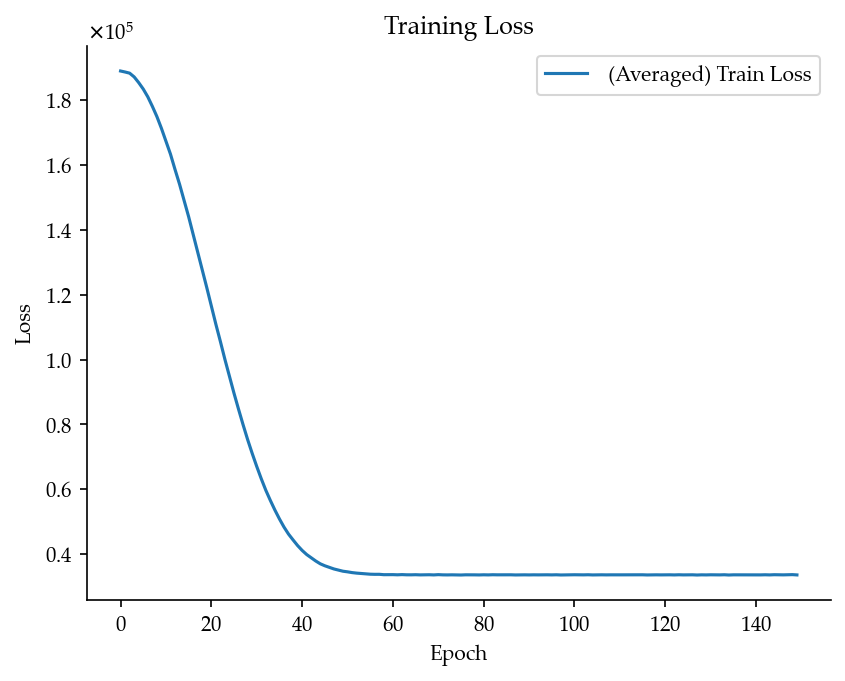

In [ ]:
# Plotting the training loss
plt.figure(dpi=150)
plt.plot(train_losses, label=' (Averaged) Train Loss')

# Remove the right and upper border lines
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Set the labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

# Adding legend
plt.legend()

# Customize the tick formatter to show significant digits
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1, 1))

# Apply the formatter to both axes
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

# Display the plot
plt.show()


In [ ]:
import os
# Create 'results' directory if it doesn't exist
results_dir = 'results'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Save the figure to the 'results' directory
plt.savefig(os.path.join(results_dir, 'training_loss.png'))

<Figure size 640x480 with 0 Axes>

In [ ]:
# Test the model on the test set after training
model.eval()
with torch.no_grad():

    test_loss_segmentation = 0
    test_loss_localization = 0
    for inputs, labels_segmentation, labels_localization in test_loader:

        inputs, labels_segmentation, labels_localization = inputs.to(device), labels_segmentation.to(device), labels_localization.to(device)
        print(f'Fault segments occur at {labels_segmentation}, fault locations occur at {labels_localization}')

        outputs_segmentation, outputs_localization = model(inputs.permute([0,2,1]))
        test_loss_segmentation += 500 * criterion_segmentation(outputs_segmentation, labels_segmentation).item()
        test_loss_localization += criterion_localization(outputs_localization, labels_localization).item()        


    avg_test_loss_segmentation = test_loss_segmentation / len(test_loader)
    avg_test_loss_localization = test_loss_localization / len(test_loader)
    print(f'Test Loss (Segmentation): {avg_test_loss_segmentation}, Test Loss (Localization): {avg_test_loss_localization}')

Fault segments occur at tensor([[[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        ...,

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]]], device='cuda:0'), fault locations occur at tensor([[228.0160, 546.0922],
        [417.8357, 176.7134],
        [580.7214, 635.8718],
        [439.6393, 381.9239],
        [135.6713, 

### Analyze saved prediction results

In [56]:
import numpy as np
import matplotlib.pyplot as plt

In [57]:
def combine_npz_files(file_paths, combined_file_path):
    combined_data = {}

    # Load and combine data from each file
    for file_path in file_paths:
        data = np.load(file_path)
        for key in data:
            if key in combined_data:
                combined_data[key] = np.concatenate((combined_data[key], data[key]), axis=0)
            else:
                combined_data[key] = data[key]

    # Save the combined data to a new .npz file
    np.savez(combined_file_path, **combined_data)


In [67]:
results = np.load('results/predict_Results_batch=1.npz')

### Fault segment location

In [68]:
results['predictedSegment']

array([[[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       ...,

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]]], dtype=float32)

In [69]:
results['trueSegment']

array([[[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       ...,

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]]], dtype=float32)

In [70]:
segment_results = np.isclose(results['predictedSegment'],results['trueSegment'])

In [71]:
segment_results

array([[[ True,  True],
        [ True,  True],
        [ True,  True],
        ...,
        [ True,  True],
        [ True,  True],
        [ True,  True]],

       [[ True,  True],
        [ True,  True],
        [ True,  True],
        ...,
        [ True,  True],
        [ True,  True],
        [ True,  True]],

       [[ True,  True],
        [ True,  True],
        [ True,  True],
        ...,
        [ True,  True],
        [ True,  True],
        [ True,  True]],

       ...,

       [[ True,  True],
        [ True,  True],
        [ True,  True],
        ...,
        [ True,  True],
        [ True,  True],
        [ True,  True]],

       [[ True,  True],
        [ True,  True],
        [ True,  True],
        ...,
        [ True,  True],
        [ True,  True],
        [ True,  True]],

       [[ True,  True],
        [ True,  True],
        [ True,  True],
        ...,
        [ True,  True],
        [ True,  True],
        [ True,  True]]])

In [72]:
# Count the total number of True values
total_true_count = np.sum(segment_results)

# Calculate the total number of elements
total_elements = segment_results.size

# Calculate the probability of an instance being True
probability_true = total_true_count / total_elements

print(f'Total True Count: {total_true_count}')
print(f'Probability of True: {probability_true:.4f}')

Total True Count: 635144
Probability of True: 0.9924


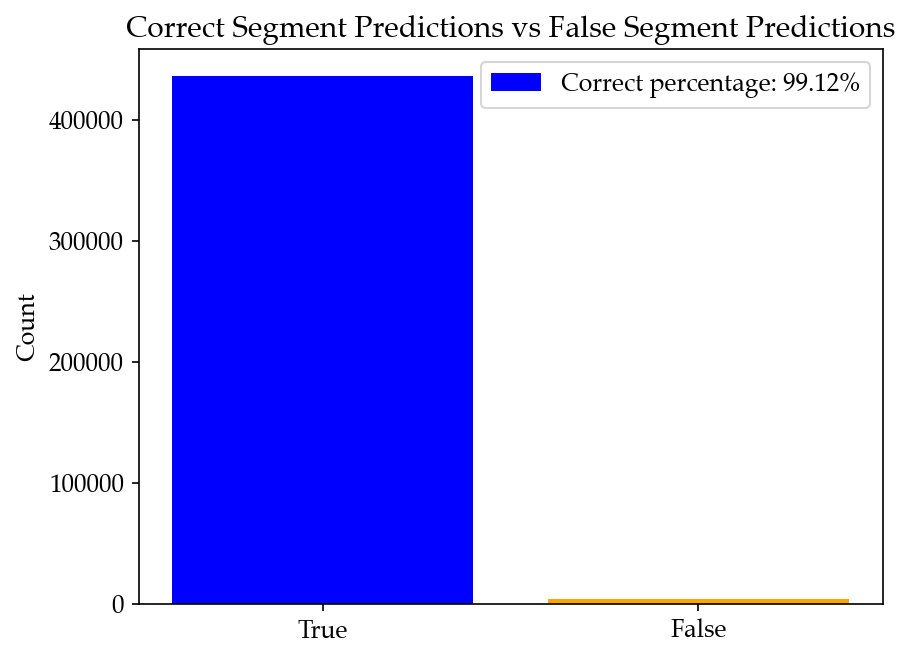

In [33]:

# Flatten the array
flattened_array = segment_results.flatten()

# Count True and False values
true_count = np.sum(flattened_array)
false_count = len(flattened_array) - true_count

# Plot the histogram
labels = ['True', 'False']
counts = [true_count, false_count]
plt.figure(dpi=150)
plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Palatino Linotype'],
        'font.size': 12
    })
plt.bar(labels, counts, color=['blue', 'orange'])
# plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Correct Segment Predictions vs False Segment Predictions')
plt.legend({'Correct percentage: 99.12%'})
plt.savefig('results/fault_segment_location.png')
plt.show()

### Precise fault localization

In [73]:
predicted_locations = results['predictedLocation']
true_locations = results['trueLocation']

In [74]:
predicted_locations

array([[349.90503, 462.2532 ],
       [358.63934, 470.21573],
       [378.8157 , 225.63757],
       [359.10522, 469.31067],
       [393.36118, 263.27084],
       [483.71133, 556.7826 ],
       [451.03073, 396.21735],
       [411.1942 , 308.76804],
       [410.64267, 503.55048],
       [378.6151 , 226.03275],
       [292.58292, 164.1217 ],
       [301.95685, 417.76675],
       [555.29645, 612.83264],
       [283.60608, 166.20613],
       [346.73907, 181.88005],
       [591.02875, 657.6952 ]], dtype=float32)

In [75]:
true_locations

array([[213.90782, 548.6573 ],
       [366.53308, 469.13828],
       [186.97395, 320.36072],
       [157.47495, 588.4168 ],
       [635.87177, 135.67134],
       [505.0501 , 546.09216],
       [129.25851, 588.4168 ],
       [692.3046 , 169.01804],
       [421.68338, 470.42084],
       [628.17633,  77.95591],
       [399.87976, 117.71543],
       [411.42285, 370.38077],
       [630.74146, 571.74347],
       [175.43086, 228.01604],
       [235.71143, 219.03807],
       [512.7455 , 700.     ]], dtype=float32)

In [76]:
rel_err = np.abs(predicted_locations-true_locations)/true_locations * 100
print(rel_err)

[[6.3577484e+01 1.5748279e+01]
 [2.1536222e+00 2.2966652e-01]
 [1.0260346e+02 2.9567654e+01]
 [1.2803960e+02 2.0241796e+01]
 [3.8138287e+01 9.4050446e+01]
 [4.2250810e+00 1.9576237e+00]
 [2.4893697e+02 3.2663830e+01]
 [4.0605019e+01 8.2683487e+01]
 [2.6182466e+00 7.0425534e+00]
 [3.9727894e+01 1.8994948e+02]
 [2.6832277e+01 3.9422421e+01]
 [2.6606691e+01 1.2793857e+01]
 [1.1961321e+01 7.1866446e+00]
 [6.1662590e+01 2.7107700e+01]
 [4.7103210e+01 1.6964184e+01]
 [1.5267470e+01 6.0435438e+00]]


In [77]:
print(rel_err.mean())

45.116013


In [78]:
print(rel_err.std())

55.22075
